In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot observed and modeled sea ice variables of interest.

'''
%load_ext autoreload
%autoreload
import matplotlib
import itertools
matplotlib.use('Agg')
import mpld3
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns


from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# from dask.distributed import Client
# client = Client()
# print(client)

#############################################################
# Load in Data
#############################################################



In [2]:
E = ed.EsioData.load()

# Load in Obs
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'obs', 'NSIDC_0081' , 'standard')

import timeit
start_time = timeit.default_timer()
# ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc',concat_dim='time', 
#                                    autoclose=True, 
#                                    compat='no_conflicts',
#                                    data_vars=['sic','extent','area'])
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True)
print(timeit.default_timer() - start_time)

# Get mean sic by DOY
mean_1980_2010_sic = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'mean_1980_2010_sic.nc')).sic

0.2337606749497354


In [3]:
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))

In [4]:
# Load in regional data
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))
#############################################################

In [5]:
# Grab sic dataArrays
da_81 = ds_81.sic

In [6]:
# Get regional averages
da_81reg = metrics.agg_by_domain(da_grid=da_81, ds_region=ds_region)

In [7]:
# Get date 30 days ago
ctime = np.datetime64(datetime.datetime.now())
lag_time_30days = ctime - np.timedelta64(30, 'D')
lag_time_90days = ctime - np.timedelta64(90, 'D')
last_sept = metrics.get_season_start_date(ctime)

# Select recent period
da_81_30 = da_81.where(da_81.time >= lag_time_30days, drop=True)
# Aggregate over domain
da_81_30_avg = metrics.calc_extent(da_81_30, ds_region, fill_pole_hole=True)

# Select recent period
da_81_3m = da_81.where(da_81.time >= lag_time_90days, drop=True)
# Aggregate over domain
da_81_3m_avg = metrics.calc_extent(da_81_3m, ds_region, fill_pole_hole=True)

In [8]:
# # Test regional sums
# da_test_nolake = ((da_81>=0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
# da_test = esio.calc_extent(da_81, ds_region, fill_pole_hole=True)
# %matplotlib inline
# da_81reg.sum(dim='nregions').plot(color='r', label='Sum of Regional Extents', linewidth=4)
# da_test_nolake.plot(color='b', label='Sum panArctic, Including Lakes')
# da_test.plot(color='k', label='Sum panArctic, Excluding Lakes')
# ds_ext.Extent.plot(color='m', label='NSIDC offical')
# plt.xlim([datetime.datetime(2018,3,1), datetime.datetime(2018,3,28)])
# plt.ylim([13.5,15])
# plt.legend()

In [9]:
# Set up plotting info
cmap_reg = matplotlib.colors.ListedColormap(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg_cycle = itertools.cycle(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg.set_bad(color = 'lightgrey')
linecycler = itertools.cycle(["-","--","-.",":","--"])

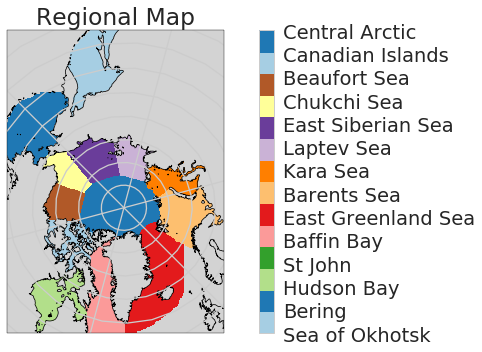

In [10]:
# Plot regional  map(s)
# Mask out other areas to missing
mask_plot = ds_region.where(ds_region.mask.isin(ds_region.ocean_regions))

(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)
p = mask_plot.mask.plot(ax=ax1,  x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),
                    cmap=cmap_reg,
                    cbar_kwargs={'label':'','ticks': ds_region.ocean_regions});
#                                  'labels':mask_plot.region_names.sel(nregions=plot_regs)})
ax1.set_title('Regional Map')
plt.tight_layout()
cb = p.colorbar
# X = list(plot_regs.values)
# X.append(16)
# X = np.array(X)-0.5
# cb.ax.set_yticks(X);
cb.ax.set_yticklabels(mask_plot.region_names.sel(nregions=ds_region.ocean_regions).values);
f.savefig(os.path.join(fig_dir,'Regional_Map.png'),bbox_inches='tight',dpi=200)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_eq

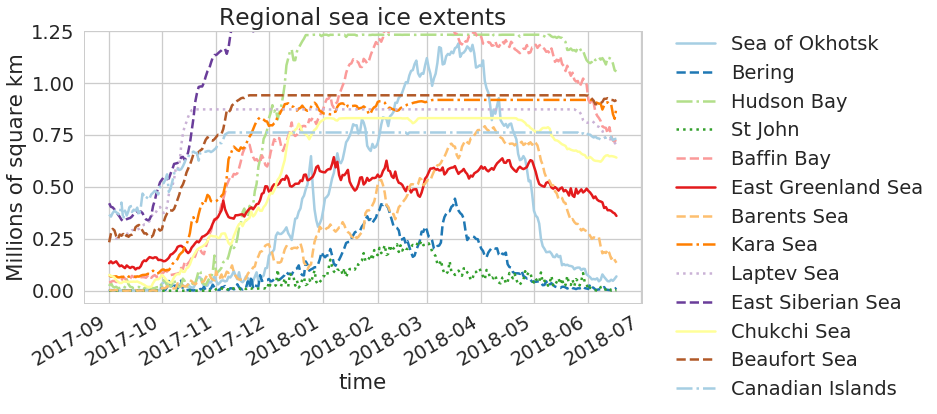

In [11]:
# Plot regional sea ice extents (last 90 days)
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
for cd in da_81reg.nregions:
    # Don't plot central arctic (boring)
    if da_81reg.region_names.sel(nregions=cd) == 'Central Arctic':
        continue
    da_81reg.where(da_81reg.time >= last_sept, 
                   drop=True).sel(nregions=cd).plot(label=da_81reg.region_names.sel(nregions=cd).values,
                                                   color=next(cmap_reg_cycle),
                                                   linestyle=next(linecycler))
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f_name = os.path.join(fig_dir,'panArcticSIC_Forecast_Regional_CurrentSeason')
f.savefig(f_name+'.png',bbox_inches='tight',dpi=200)
mpld3.save_json(f, f_name+'.json')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


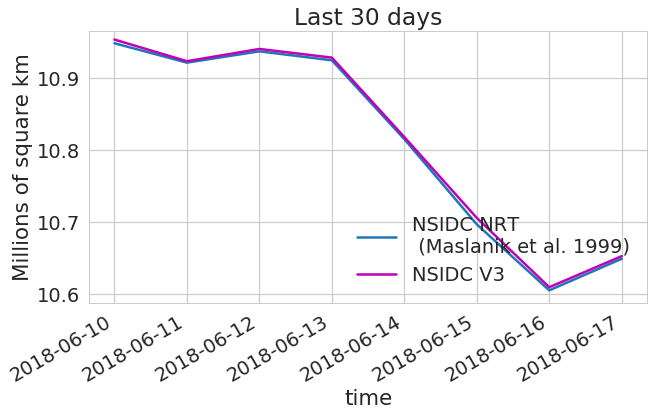

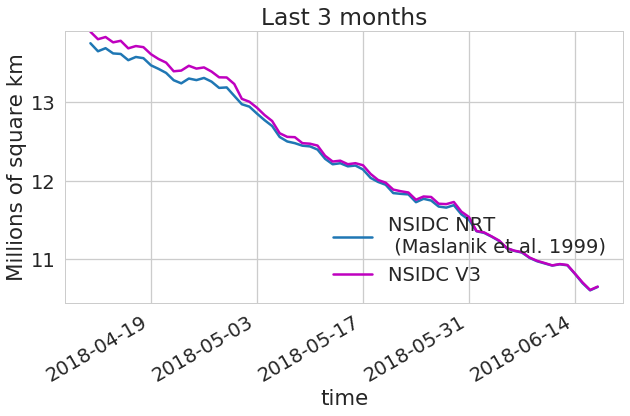

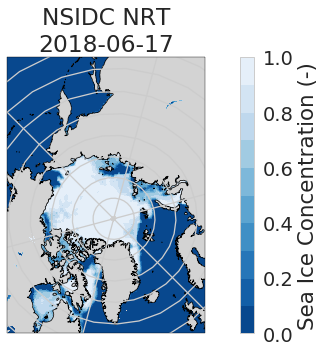

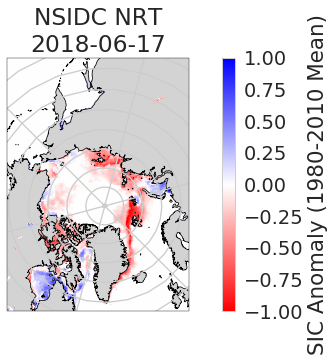

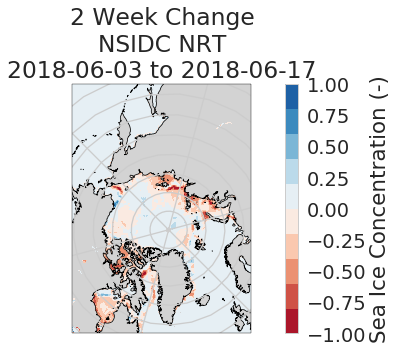

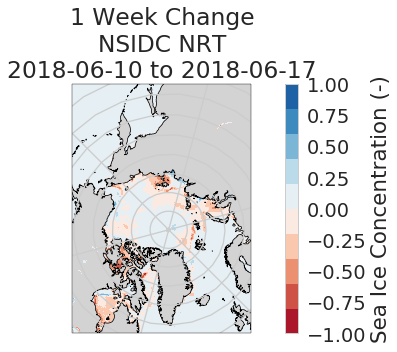

In [12]:
## Plot Extents



# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
da_81_30_avg.plot(ax=ax1, label='NSIDC NRT\n (Maslanik et al. 1999)')
ds_ext.sel(datetime=da_81_30_avg.time).Extent.plot(label='NSIDC V3', color='m')
ax1.set_ylabel('Millions of square km')
plt.legend(loc='lower right') #bbox_to_anchor=(1.03, 1.05))
# Save to png and json (for website)
f_name = os.path.join(fig_dir,'panArcticSIC_Forecast_30days')
plt.title('Last 30 days')
f.savefig(f_name+'.png',bbox_inches='tight',dpi=200)
mpld3.save_json(f, f_name+'.json')
mpld3.save_html(f, f_name+'.html')


## Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
da_81_3m_avg.plot(ax=ax1, label='NSIDC NRT\n (Maslanik et al. 1999)')
ds_ext.sel(datetime=da_81_3m_avg.time).Extent.plot(label='NSIDC V3', color='m')
plt.title('Last 3 months')
ax1.set_ylabel('Millions of square km')
plt.legend(loc='lower right')
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_3months.png'),bbox_inches='tight',dpi=200)


# Plot Recent maps

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')
cmap_dif = matplotlib.colors.ListedColormap(sns.color_palette("RdBu", 10))
cmap_dif.set_bad(color = 'lightgrey')


cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
cmap_diff_2.set_bad(color = 'lightgrey')


# Plot Obs and model SIC for date
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)
# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
obs1.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('NSIDC NRT\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map.png'),bbox_inches='tight',dpi=200)



(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)
# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
cdoy = pd.to_datetime(ctime).timetuple().tm_yday
(obs1-mean_1980_2010_sic.isel(time=cdoy)).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_diff_2,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'SIC Anomaly (1980-2010 Mean)'})
ax1.set_title('NSIDC NRT\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_SIC_anomaly.png'),bbox_inches='tight',dpi=200)


# Plot obs change from yesterday
# Plot Obs and model SIC for date
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(14, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('2 Week Change\nNSIDC NRT\n'+pd.to_datetime(obs2.time.values).strftime('%Y-%m-%d')+' to '+ 
             pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_2Week_Change.png'),bbox_inches='tight',dpi=200)


# Plot obs change from last week
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(10, 5)
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(7, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('1 Week Change\nNSIDC NRT\n'+pd.to_datetime(obs2.time.values).strftime('%Y-%m-%d')+' to '+ 
             pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'))
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_1Week_Change.png'),bbox_inches='tight',dpi=200)